In [76]:
import cv2
import numpy as np
from PIL import Image
import IPython
import matplotlib.pyplot as plt

## write function that shows image in jupyter notebook
def display(img):
    pil_image = Image.fromarray(img)
    SCALE = 2
    width, height = pil_image.size
    pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)
    IPython.display.display(pil_image)


256 192 3


/var/folders/py/4vk30n9d0w97lw28czjywqwh0000gn/T/ipykernel_20065/3992334537.py:12: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)


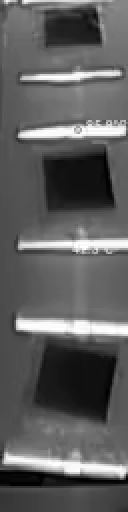

In [77]:
# Load video capture from file
cap = cv2.VideoCapture('thermal.mp4')

# Grab first frame to get resolution
ret, frame = cap.read()
height, width, channels = frame.shape
print (height, width, channels)

# assure grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)



# crop only center third of the image as a stripe
frame = frame[:, width//3:2*width//3]

display(frame)


/var/folders/py/4vk30n9d0w97lw28czjywqwh0000gn/T/ipykernel_20065/3992334537.py:12: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)


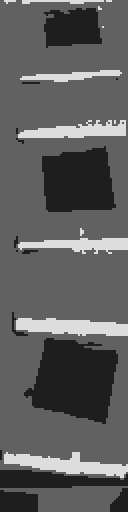

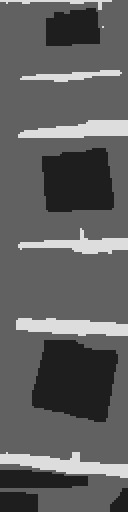

In [80]:

# segment using kmeans into 3 clusters
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
Z = frame.reshape((-1,1))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res = res.reshape((frame.shape))

display(res)

# dilate erosion to remove noise
kernel = np.ones((5,5),np.uint8)
res = cv2.dila
te(res,kernel,iterations = 1)
res = cv2.erode(res,kernel,iterations = 1)

display(res)
